In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import ldamodel
from gensim.parsing.preprocessing import STOPWORDS
import wikipedia

#### Get some wikipedia articles (as corpus)

In [2]:
computer_science = ["Algorithm", "Computation", "Computer Programming", 
                    "Programming Language","Computational complexity theory",
                    "Computability theory", "Artificial Intelligence"]

philosophy = ["Epistemology", "Metaphysics", "Continental philosophy" 
              "Ancient Greek", "Ethics", "Aesthetics", 
              "Art", "Phenomenology (philosophy)", "Pythagoras", "Plato"]

linguistics = ["Language" ,"Semantics", "Syntax", "Phonology", "Grammar",
               "Phonetics", "Pragmatics",  "Corpus linguistics", 
               "Linguistic prescription", "Linguistic description"]
articles = computer_science + philosophy + linguistics
documents = [wikipedia.page(title).content for title in articles]
np.save("docs", documents)

In [3]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

def preprocessing(documents):
    special_chars = set('== ==='.split())
    # remove common words and tokenize
    texts = [[word for word in document.lower().split() if word not in STOPWORDS and 
              word not in special_chars] 
             for document in documents]

    # remove words that appear only once
    all_tokens = sum(texts, [])
    tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
    texts = [[word for word in text if word not in tokens_once] for text in texts]

    dictionary = corpora.Dictionary(texts)
    preprocessed_docs = [dictionary.doc2bow(text) for text in texts]  # bow = bag of words
    return preprocessed_docs, dictionary

In [4]:
CORPUS, dictionary = preprocessing(np.load("docs.npy"))

In [6]:
K = 3 # number of topics
lda = ldamodel.LdaModel(CORPUS, id2word=dictionary, 
                        num_topics=K, update_every=1, 
                        chunksize=1, passes=350)
corpus_lda = lda[CORPUS]
np.save("lda", lda)
for i in range(K):
    print "TOPIC #" + str(i+1) + ":   "+ lda.print_topic(i) + "\n"

TOPIC #1:   0.010*programming + 0.009*turing + 0.008*problem + 0.007*machine + 0.006*problems + 0.006*algorithms + 0.006*algorithm + 0.006*set + 0.006*complexity + 0.005*time

TOPIC #2:   0.008*plato + 0.006*plato's + 0.006*knowledge + 0.005*pythagoras + 0.005*philosophy + 0.004*phenomenology + 0.004*greek + 0.004*according + 0.004*socrates + 0.003*theory

TOPIC #3:   0.019*language + 0.009*languages + 0.007*art + 0.005*meaning + 0.005*linguistic + 0.005*human + 0.004*ethics + 0.004*speech + 0.004*study + 0.004*grammar



In [9]:
w = wikipedia.page("Noam Chomsky").content

bow_vector = dictionary.doc2bow(tokenize(w))
#print [(dictionary[id], count) for id, count in bow_vector]
print lda[bow_vector]

[(0, 0.032599745516170064), (1, 0.30504589551791855), (2, 0.66235435896591133)]


In [10]:
def topic_distribution(lda_corpus_model):
    data = {}
    for i, dist in enumerate(lda_corpus_model):
        distribution = np.array([0.01,0.01,0.01])
        for topic_weight in dist:
            distribution[topic_weight[0]] = topic_weight[1]
        data.update({articles[i]: distribution})
    return data
        
def printArticleDistribution(lda_corpus_model):
    for i, dist in enumerate(lda_corpus_model):
        print articles[i]
        print dist

data = topic_distribution(list(lda[CORPUS]))
#printArticleDistribution(list(lda[CORPUS]))

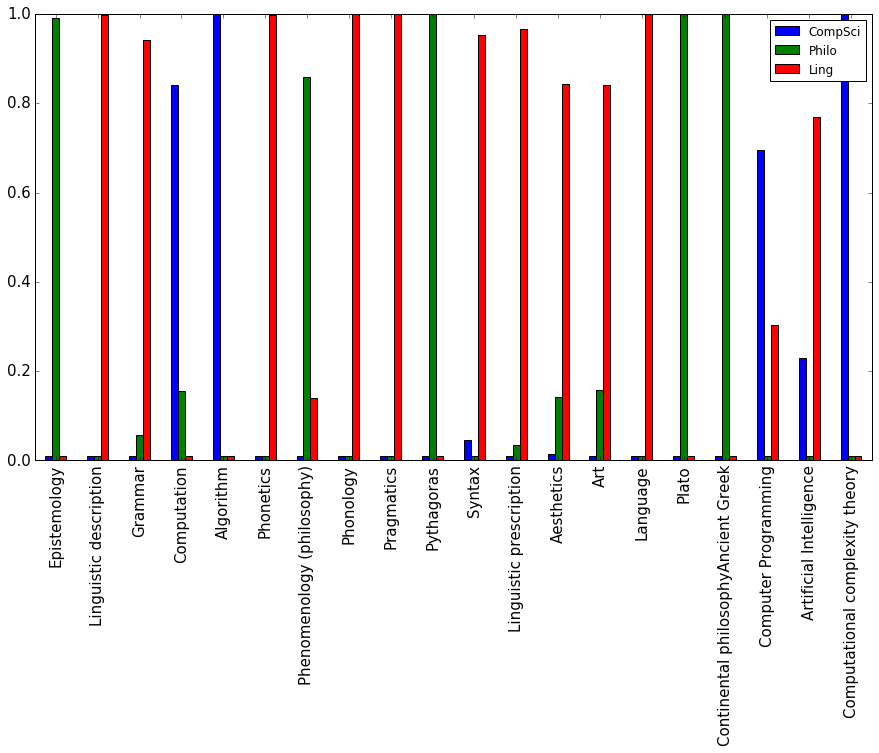

In [12]:
n = 20
df2 = pd.DataFrame(np.array(data.values())[:n], columns=["CompSci", "Philo", "Ling"], 
                   index=data.keys()[:n])
df2.plot.bar(figsize=(15,8), fontsize=15);